In [1]:
import os
import sys
import glob
import joblib
import pathlib
import numpy as np
import pandas as pd
from rich.progress import track

sys.path.append("../src")

from utils import timer
from utils import load_pickle, dump_pickle, save_cache

In [2]:
waypoints = load_pickle("../data/working/train_waypint.pkl")

Load pickle from ../data/working/train_waypint.pkl


In [3]:
(site, floor, path, timestamp, x, y) = waypoints[100]
(site, floor, path, timestamp, x, y)

('5da138764db8ce0c98bcaa46',
 'F4',
 '5dac3df0dc3e2c0006606b3e',
 '1571569077016',
 '29.686214',
 '105.78036')

In [4]:
path_filepath = f"../data/raw/train/{site}/{floor}/{path}.txt"
path_filepath

'../data/raw/train/5da138764db8ce0c98bcaa46/F4/5dac3df0dc3e2c0006606b3e.txt'

In [5]:
def get_data_from_pathtxt(
    filepath: pathlib.PosixPath, data_type: str, is_join_ids: bool = False
) -> np.ndarray:
    with open(filepath) as f:
        lines = f.readlines()

    data = []
    for line in lines:
        tmp = line.strip().split("\t")
        if tmp[1] == data_type:
            data.append(tmp)

    data = np.array(data)
    # Drop data_type column.
    if data.shape[0] > 0:
        data = np.delete(data, 1, axis=1)
    # Concatenate site, floor and path.
    if is_join_ids:
        site_id = filepath.parent.parent.name
        floor_id = filepath.parent.name
        path_id = filepath.name.split(".")[0]
        site_floor_path = np.tile([site_id, floor_id, path_id], (data.shape[0], 1))
        data = np.concatenate([site_floor_path, data], axis=1)
    return data

In [6]:
wifi = get_data_from_pathtxt(path_filepath, "TYPE_WIFI")

In [7]:
wifi.shape

(2940, 6)

In [8]:
# (timestamp, ssid, bssid, rssi, frequency, last_seen_timestamp)
wifi

array([['1571568986917', '297a8d1a48933caa2a09eaab54d0e35346f972dd',
        '83000082f8f021c6345db980100e8c4e382139d6', '-56', '2437',
        '1571568985392'],
       ['1571568986917', '0e458bee6676d2750897cc993403f3281265da5a',
        'a52e35e9553ff4c8dabc153223c5ce6ad3a65d53', '-59', '2462',
        '1571568985690'],
       ['1571568986917', 'da39a3ee5e6b4b0d3255bfef95601890afd80709',
        '46dfa0c635bd24cbec6b2c11d788c0171ded4b73', '-63', '2437',
        '1571568981620'],
       ...,
       ['1571569079692', '050cf323c40ef3f06a59821e01e1d2d0ee288933',
        '075279c87b146b78e89ce57d36bd6956135ae876', '-91', '5745',
        '1571569078904'],
       ['1571569079692', 'b01857e452a84ace381ac545896264c61ac82a57',
        '5db8a385607a001cae8da5f069e1005f527ae7d6', '-91', '2437',
        '1571569078171'],
       ['1571569079692', '8528fee688615788736815acdbefb0a406e48817',
        'c0c2323f31057756600cf9fd371219c4cef1a817', '-92', '2437',
        '1571569068604']], dtype='<U40')

In [9]:
max_len = 100
wifi = get_data_from_pathtxt(path_filepath, "TYPE_WIFI")

data = np.concatenate(
    [
        np.tile("nan", (1, 100)).astype("<U40"),  # bssid
        np.tile("-999", (1, 100)).astype("<U40"),  # rssi
        np.tile("-999", (1, 100)).astype("<U40"),  # frequency
        np.tile("999", (1, 100)).astype("<U40"),  # ts_diff
        np.tile("999", (1, 100)).astype("<U40"),  # last_seen_ts_diff
    ],
    axis=0,
)

if len(wifi) > 0:
    ts_diff = wifi[:, 0].astype("int64") - int(timestamp)
    last_seen_ts_diff = wifi[:, 5].astype("int64") - int(timestamp)
    # Add ts_diff and last_seen_ts_diff as feature.
    wifi = np.concatenate([wifi, ts_diff.reshape(-1, 1)], axis=1)
    wifi = np.concatenate([wifi, last_seen_ts_diff.reshape(-1, 1)], axis=1)
    # Extract latest values, except feature information.
    wifi = wifi[(ts_diff < 0)]
    # Sort by rssi
    sort_idx = np.argsort(wifi[:, 3].astype(int))[::-1]
    wifi = wifi[sort_idx]
    # Extract columns of (bssid, rssi, frequency, ts_diff, last_seen_ts_diff).
    wifi = wifi[:, [2, 3, 4, 6, 7]]
    end_idx = min(max_len, wifi.T.shape[1])
    data[:, :end_idx] = wifi.T[:, :end_idx]

In [10]:
data

array([['a52e35e9553ff4c8dabc153223c5ce6ad3a65d53',
        'a52e35e9553ff4c8dabc153223c5ce6ad3a65d53',
        '83000082f8f021c6345db980100e8c4e382139d6',
        'a52e35e9553ff4c8dabc153223c5ce6ad3a65d53',
        '83000082f8f021c6345db980100e8c4e382139d6',
        'a52e35e9553ff4c8dabc153223c5ce6ad3a65d53',
        'a52e35e9553ff4c8dabc153223c5ce6ad3a65d53',
        '83000082f8f021c6345db980100e8c4e382139d6',
        '83000082f8f021c6345db980100e8c4e382139d6',
        'a52e35e9553ff4c8dabc153223c5ce6ad3a65d53',
        '83000082f8f021c6345db980100e8c4e382139d6',
        'a52e35e9553ff4c8dabc153223c5ce6ad3a65d53',
        'a52e35e9553ff4c8dabc153223c5ce6ad3a65d53',
        '83000082f8f021c6345db980100e8c4e382139d6',
        '83000082f8f021c6345db980100e8c4e382139d6',
        'a52e35e9553ff4c8dabc153223c5ce6ad3a65d53',
        'a52e35e9553ff4c8dabc153223c5ce6ad3a65d53',
        '83000082f8f021c6345db980100e8c4e382139d6',
        '83000082f8f021c6345db980100e8c4e382139d6',
        'a52

## Check processing data

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn-darkgrid')

In [91]:
wifi_train = load_pickle("../data/working/train_wifi.pkl")

Load pickle from ../data/working/train_wifi.pkl


### rssi

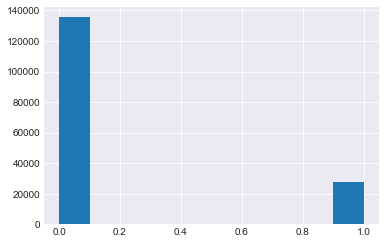

In [41]:
tmp = wifi_train[:, 1].astype('int64')

plt.figure()
plt.hist(np.mean(tmp==-999, axis=1), bins=10)
plt.show()

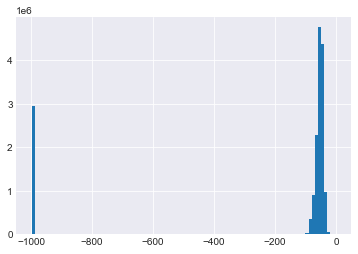

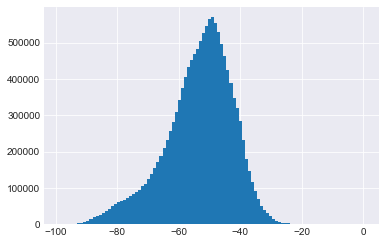

In [44]:
rssi = wifi_train[:, 1].astype('int64')
rssi = rssi.ravel()

plt.figure()
plt.hist(rssi, bins=100)
plt.show()

# NOTE: 欠損値を除いた場合の分布

_rssi = rssi[rssi != -999]

plt.style.use('seaborn-darkgrid')

plt.figure()
plt.hist(_rssi, bins=100)
plt.show()

In [52]:
rssi = wifi_train[:, 1].astype('int64')
rssi = rssi.ravel()

rssi[rssi == -999] = rssi[rssi != -999].mean()

In [62]:
print("rssi の平均値")
np.median(rssi[rssi != -999])

rssi の平均値


-53.0

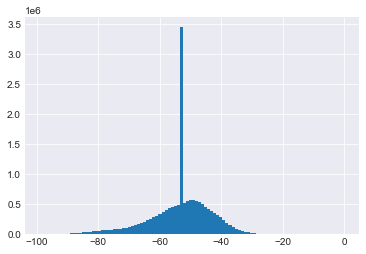

In [53]:
plt.figure()
plt.hist(rssi, bins=100)
plt.show()

### frequency

値があれすぎていて

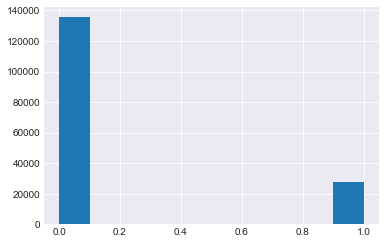

In [68]:
tmp = wifi_train[:, 2].astype('int64')

plt.figure()
plt.hist(np.mean(tmp==-999, axis=1), bins=10)
plt.show()

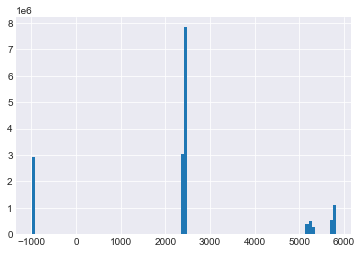

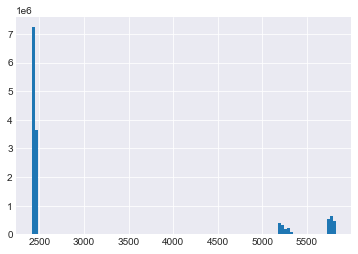

In [69]:
freq = wifi_train[:, 2].astype('int64')
freq = freq.ravel()

plt.figure()
plt.hist(freq, bins=100)
plt.show()

# NOTE: 欠損値を除いた場合の分布

_freq = freq[freq != -999]

plt.style.use('seaborn-darkgrid')

plt.figure()
plt.hist(_freq, bins=100)
plt.show()

### ts_diff


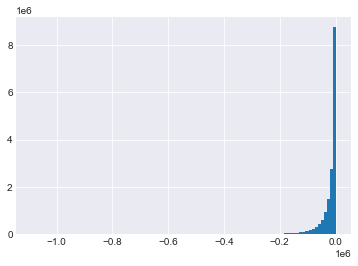

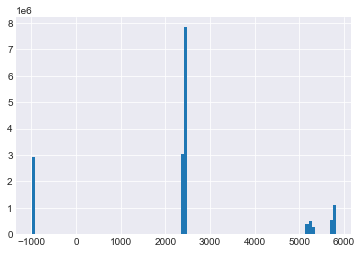

In [71]:
ts_diff = wifi_train[:, 3].astype('int64')
ts_diff = ts_diff.ravel()

plt.figure()
plt.hist(ts_diff, bins=100)
plt.show()

# NOTE: 欠損値を除いた場合の分布

_ts_diff = freq[freq != 999]

plt.style.use('seaborn-darkgrid')

plt.figure()
plt.hist(_ts_diff, bins=100)
plt.show()

### last_seen_ts_diff

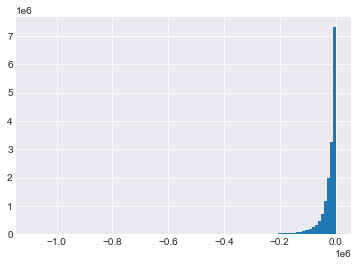

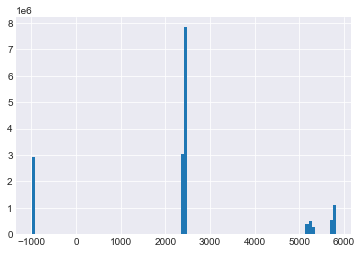

In [73]:
ts_diff = wifi_train[:, 4].astype('int64')
ts_diff = ts_diff.ravel()

plt.figure()
plt.hist(ts_diff, bins=100)
plt.show()

# NOTE: 欠損値を除いた場合の分布

_ts_diff = freq[freq != 999]

plt.style.use('seaborn-darkgrid')

plt.figure()
plt.hist(_ts_diff, bins=100)
plt.show()